# Evaluate resolving ability of the CNN model on synthetic data

* Input data were created using script `generate_inputs.py`. The data contain one or two PSFs placed in the central row of the image. In the first frame of each dataset, there is just one emitter. Then the emitters are gradually separated with step of 1/80 of Rayleigh distance. The data contains several tested levels of signal to noise ratio.

* The input data are then fed into the CNN and outputs are saved into another h5 file, holding the structure, see script `process_inputs_cnn.py`.
* This notebook analyses the CNN output. Because the emitters are having the same vertical position, we can can simplify the problem from 2D to 1D by evaluating marginal of the CNN output. Two emitters are resolved if:
    * (a) We see (at least) two distinc peaks in the data. We define peaks as contiguous regions of points that are higher than 20% of global maximum.
    * (b) Or if there is a double-peak, it has to have a dip of 26.3%. In case of uneven local maximum, the dip is related to the lower one.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
# Get info from generator
from generate_inputs import MONTE_CARLO_SAMPLES, PSFW, RAYLEIGH, WIDTH, HEIGHT, UPSCALE, snrs, distances
snrs_mc = np.kron(snrs, np.ones(MONTE_CARLO_SAMPLES))
# print(PSFW, RAYLEIGH)
print("half of sampling step:", (distances[1]-distances[0])*0.5/RAYLEIGH, 'Rayleigh')

def is_resolvable(signal):
    """
    Check whether a 1D signal contains at least two distinct peaks or a double peak
    with a 26.3% dip modulation in between. In the case of uneven double peaks, the
    lower peak is taken as a reference.

    Parameters:
        signal (np.ndarray): 1D array representing the signal to analyze.

    Returns:
        bool: True if the signal is resolvable (contains distinct peaks or meets the
              dip modulation criteria), False otherwise.
    """
    # Normalize the 1D array
    sn = signal / np.max(signal)

    # Select all points higher than 20% of the maximum and identify regions of these peaks
    sel = (sn > 0.2).astype(int)
    rising = np.diff(sel) > 0.1
    falling = np.diff(sel) < -0.1
    rising_count = sum(rising)
    falling_count = sum(falling)
    #starts = [i for i, r in enumerate(rising) if r]
    #stops = [i for i, r in enumerate(falling) if r]
    # If we detect two distinct peaks, they are clearly resolvable
    if (rising_count >= 2) and (falling_count >= 2):
        if rising_count == falling_count:
            return True
    # In case of two distinct peaks, take the smaller as the dip reference
    # Detect sub-peaks by detecting zero-crossings of the first derivative
    # and conditioning it on negative values of the second derivative
    d2 = np.diff(np.sign(np.diff(sn)))
    mxms = (d2 < -1) * (sn[1:-1] >= 0.5)
    sub_peak_values = sorted(sn[1:-1][mxms])
    if len(sub_peak_values) < 2:
        min_peak = 1
    else:
        min_peak = sub_peak_values[-2]

    # Set 26.3% dip as a reference value
    # If we detect two distinct regions higher than this, we call peaks resolvable
    hi = sn >= min_peak * (1 - 0.263)
    dhi = np.diff(hi.astype(np.float32))
    rising = dhi > 0.1
    falling = dhi < -0.1
    rising_count = sum(rising)
    falling_count = sum(rising)
    if (rising_count >= 2) and (falling_count >= 2):
        return True

    return False

half of sampling step: 0.006250000000000001 Rayleigh


In [2]:
#Load data
with h5py.File('cnn_output_res_psf2hr.h5', 'r') as h5f:
    cnndata = {key : np.array(h5f[key]).reshape((-1,200,200)) for key in h5f.keys()}

with h5py.File('input_res_for_cnn_psf2hr.h5', 'r') as h5f:
    inpdata = {key : np.array(h5f[key]).reshape((-1,50,50)) for key in h5f.keys()}

# Group dataset names/keys by their SNR value.
key_dict = dict()
counter = 0
for snr in snrs_mc:
    key = f'snr_{int(round(snr)):d}_{counter}' if snr>0 else 'noiseless'
    counter += 1
    key_dict[key] = snr
        
snr_groups = dict()
for key in cnndata:
    if 'snr' not in key:
        continue
    identifier, snrval, trial = key.split('_')
    snrkey = f'{key_dict[key]:.1f}'
    if snrkey in snr_groups:
        snr_groups[snrkey].append(key)
    else:
        snr_groups[snrkey] = [key]
sorted_snr_keys = sorted(snr_groups.keys(), key = lambda x: float(x))
snr_table = np.array(list(map(float, sorted_snr_keys)))


In [3]:
def estimate_resolution(snrkey):
    """
    A helper function. Evaluate resolving power for all datasets of same SNR.
    Return mean minimal resolvable distances, standard deviation and percentage of 
    datasets in which the emitters were at least once resolvable.
    """
    keys = snr_groups.get(snrkey)
    arr = []
    #iterate over all dataset with the same SNR
    succ_counter = 0
    tot_counter = 0
    for key in keys:        
        #iterate the frames in the dataset
        #first frame contains one emitter, others contain
        #gradually separating two emitters
        d_index = 0
        tot_counter += 1
        for i, dframe in enumerate(cnndata[key]):            
            #calculate normalized marginal
            marginal = np.mean(dframe, axis=0)
            marginal /= np.max(marginal)
            #determine whether we can resolve the emitters
            resolvable = is_resolvable(marginal)
            if resolvable:
                #once we hit the first frame with resolvable emitters,
                #break make an entry
                arr.append(distances[i])
                succ_counter += 1
                break
    #from 10 monte carlo samples, calculate mean and std
    mean_dist = np.mean(arr)/RAYLEIGH
    std_dist = np.std(arr)/RAYLEIGH
    return mean_dist, std_dist, succ_counter/tot_counter

# Evaluate resolving power for each tested SNR.
evaluated_performance = []
for snrval, skey in zip(snr_table, sorted_snr_keys):
    if snrval <= 2:
        continue
    x, dx, s = estimate_resolution(skey)
    evaluated_performance.append((snrval, x, dx, s))
    print(f'{snrval:.1f} {x:.03f}+/-/{dx:.03f}, {s*100:.0f}%')

evaluated_performance = np.array(evaluated_performance)

2.2 0.479+/-/0.175, 100%
2.6 0.600+/-/0.081, 100%
3.2 0.524+/-/0.091, 100%
3.8 0.490+/-/0.078, 100%
4.6 0.420+/-/0.124, 100%
5.6 0.363+/-/0.097, 100%
6.8 0.312+/-/0.086, 100%
8.3 0.200+/-/0.087, 100%
10.0 0.164+/-/0.066, 100%
12.1 0.089+/-/0.067, 100%
14.7 0.097+/-/0.067, 100%
17.8 0.064+/-/0.048, 100%
21.5 0.086+/-/0.050, 100%
26.1 0.113+/-/0.045, 100%
31.6 0.128+/-/0.031, 100%
38.3 0.120+/-/0.043, 100%
46.4 0.134+/-/0.024, 100%
56.2 0.135+/-/0.021, 100%
68.1 0.130+/-/0.026, 100%
82.5 0.152+/-/0.009, 100%
100.0 0.149+/-/0.010, 100%
121.2 0.152+/-/0.007, 100%
146.8 0.149+/-/0.007, 100%
177.8 0.144+/-/0.006, 100%
215.4 0.146+/-/0.006, 100%
261.0 0.148+/-/0.005, 100%
316.2 0.146+/-/0.006, 100%
383.1 0.146+/-/0.006, 100%
464.2 0.143+/-/0.006, 100%
562.3 0.144+/-/0.006, 100%
681.3 0.140+/-/0.005, 100%
825.4 0.146+/-/0.006, 100%
1000.0 0.137+/-/0.000, 100%


## Resolving power VS SNR

Note: at SNRs 10-30, there is an apparent dip. This is due to noise that propagates into CNN output, which can turn into random sub-peaks in the marginalia. The errorbars indicate the increased level of noise there.

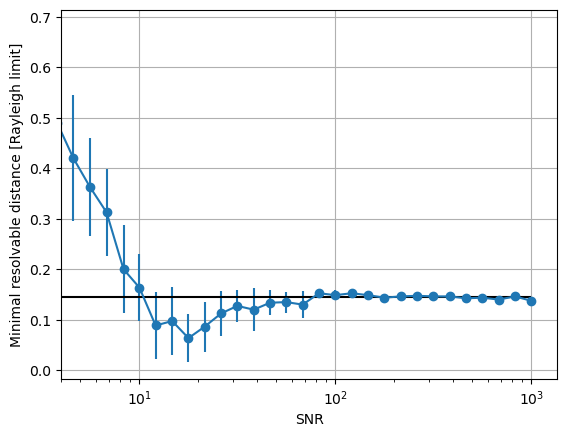

0.14400000000000002


In [10]:
# plt.semilogx(evaluated_performance[:,0],evaluated_performance[:,1], "o-", label='minimal resolvable distance')
fig, ax = plt.subplots()
ax.errorbar(x=evaluated_performance[:,0], y=evaluated_performance[:,1], yerr = evaluated_performance[:,2], fmt="o-", label='minimal resolvable distance')
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('SNR')
ax.set_ylabel('Minimal resolvable distance [Rayleigh limit]')
ax.set_xlim(4, None)
ax.hlines([1.45e-1],3,1000, colors='k')
plt.show()
print(np.mean(evaluated_performance[-10:,1]))

# save results for later plotting
# with h5py.File('results_psf2.h5', 'w') as h5f:
#     dset = h5f.create_dataset('table', data = evaluated_performance)
#     dset.attrs['info'] = ('snr', 'rel_resolution_mean', 'rel_resolution_std', 'conclusiveness')


## Plot examples of marginalia

Note the behaviour that up to some distances, the CNN returns always a single emitter but then suddenly, two emitters appear in the output.

For each SNR, we produce a pseudo-color image. In that image, each line represents a marginalia for a single separation. In red channel we plot the the CNN output and in the green channel we plot the corresponding input marginalia. Red line shows the resolution threshold. 

Then we also plot the marginalias for a single emitter (black), last unresolved frame (orange), and the first resolved frame (blue). The marginalias were averaged over all 10 monte carlo samples (and CNN outputs) to show the trends.

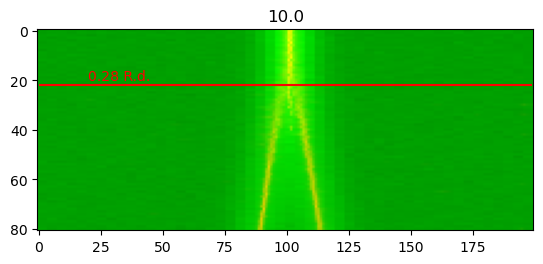

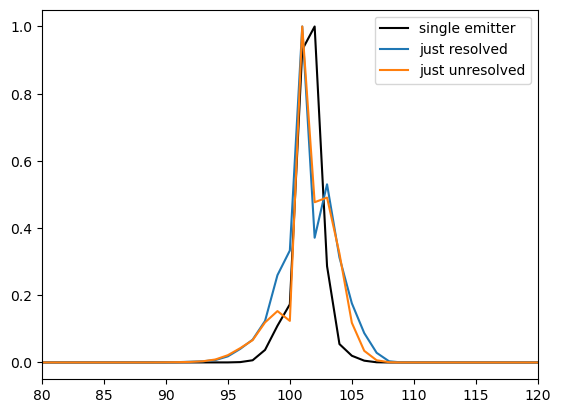

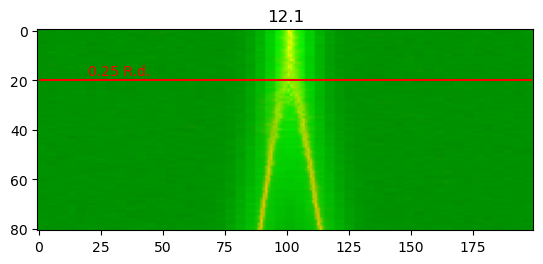

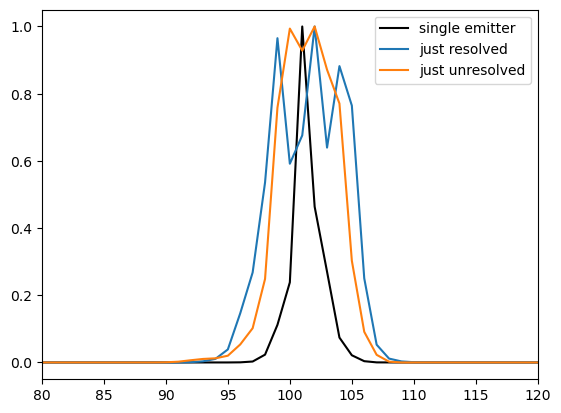

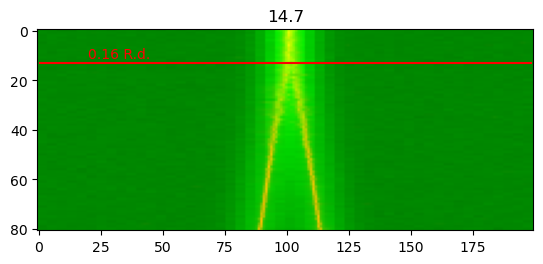

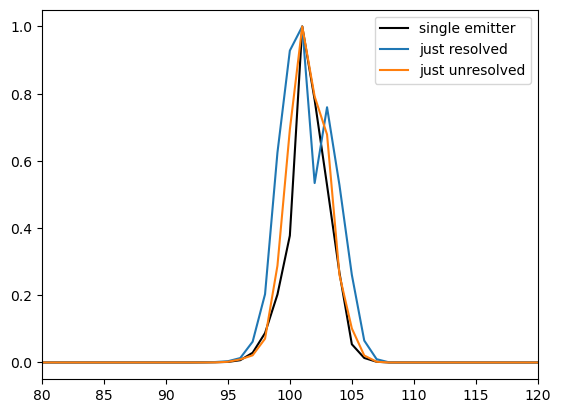

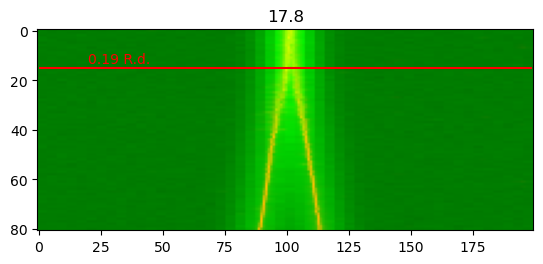

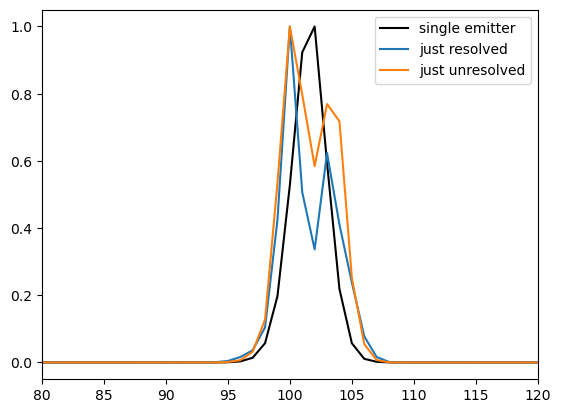

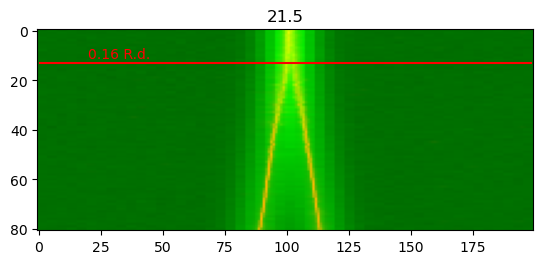

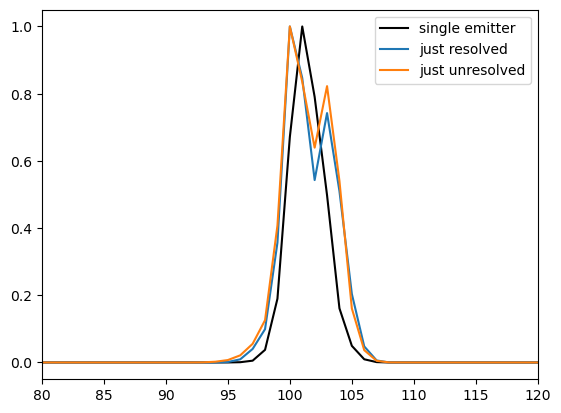

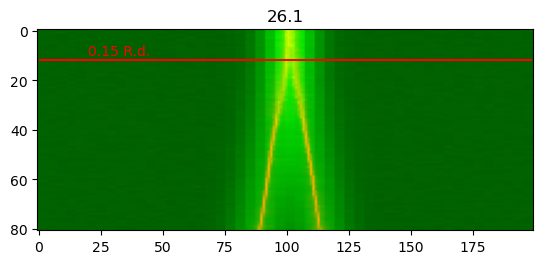

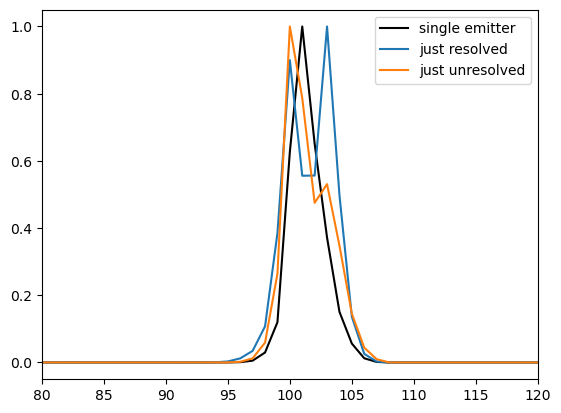

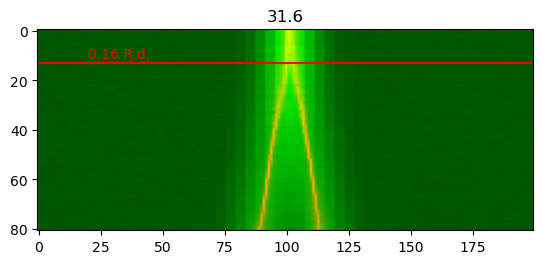

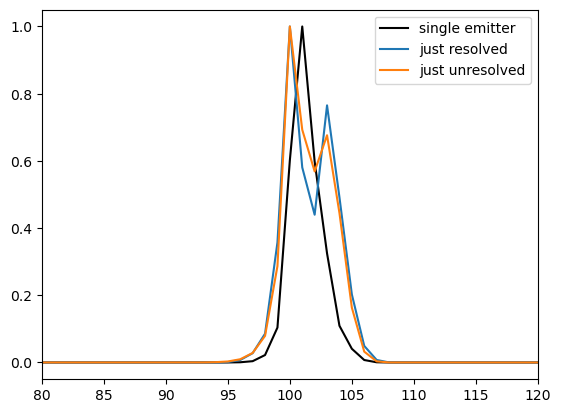

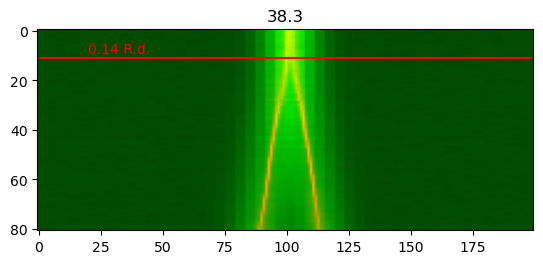

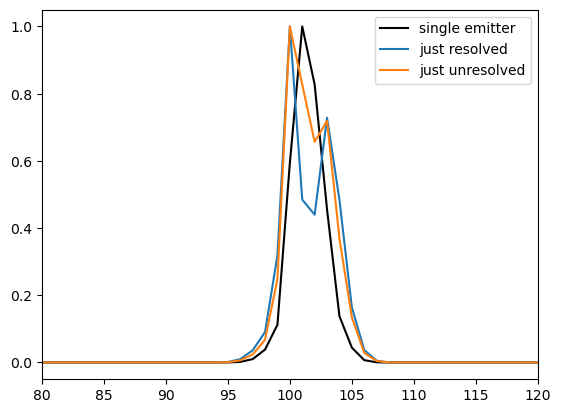

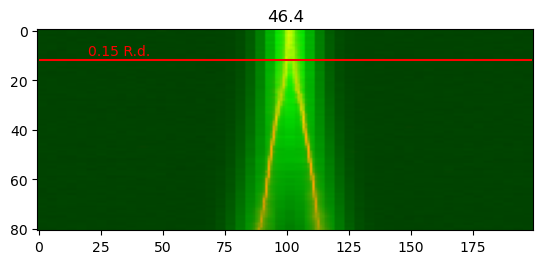

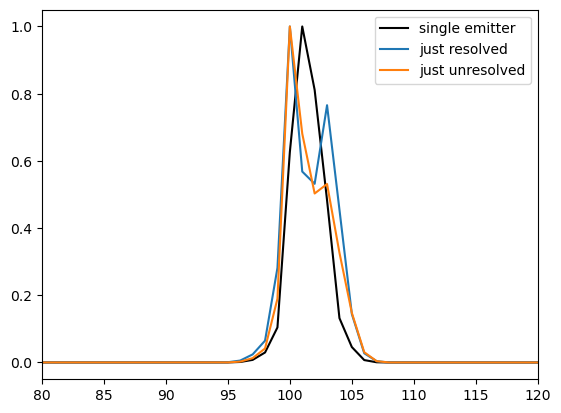

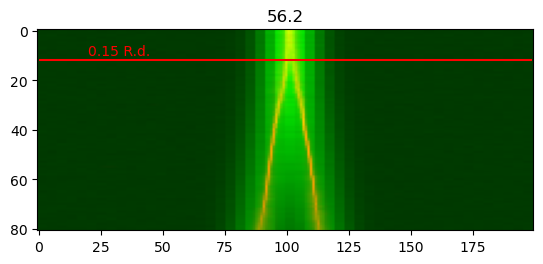

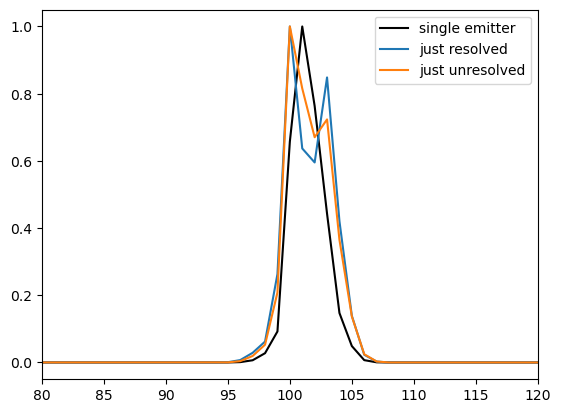

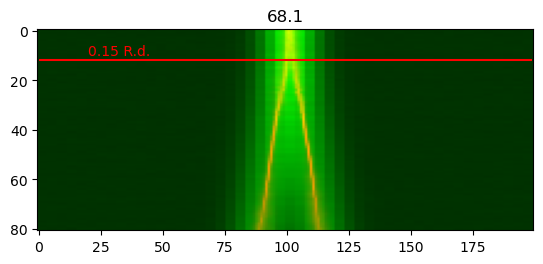

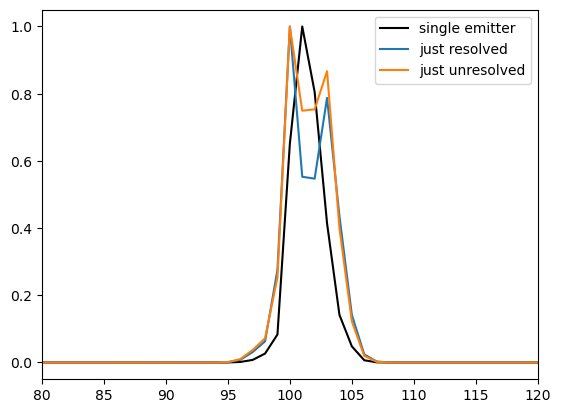

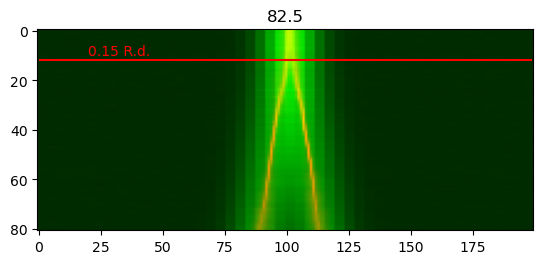

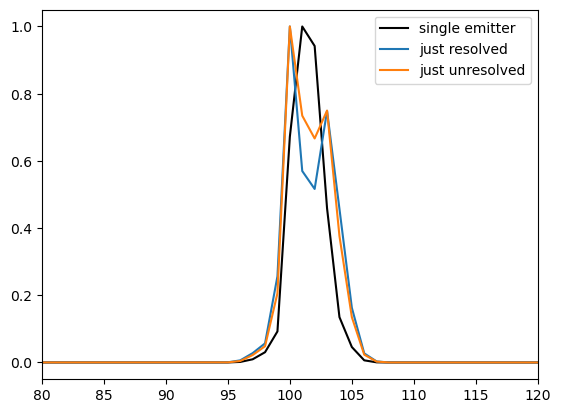

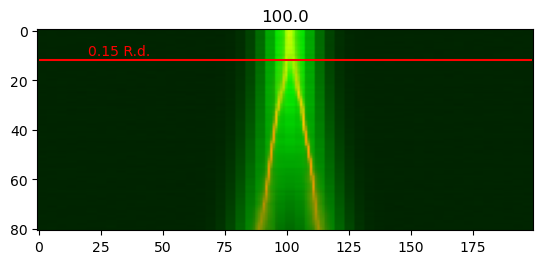

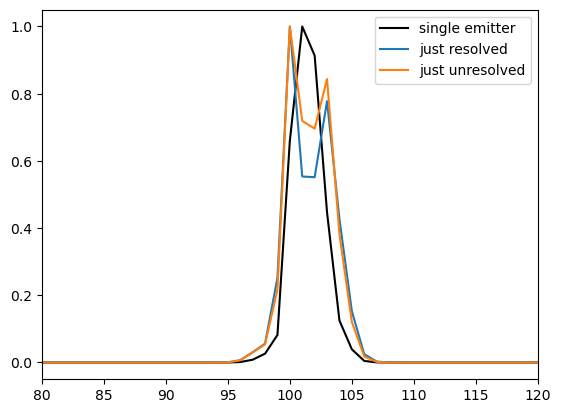

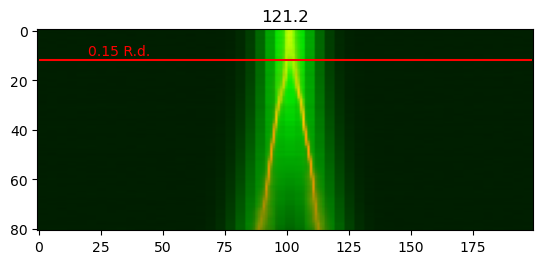

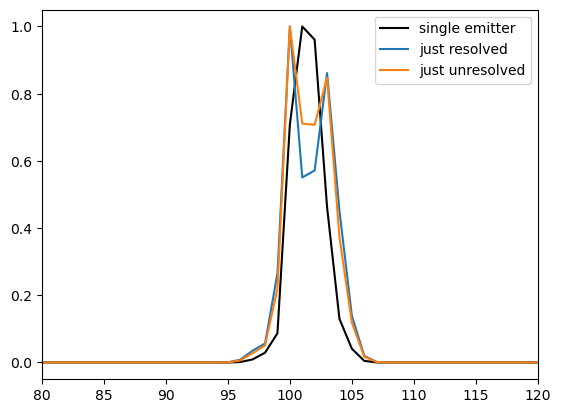

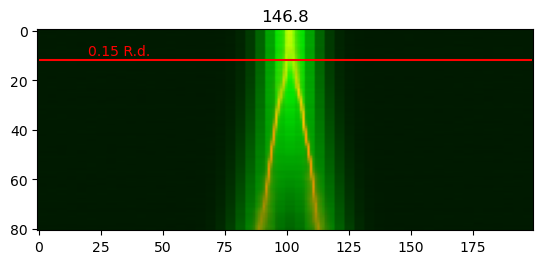

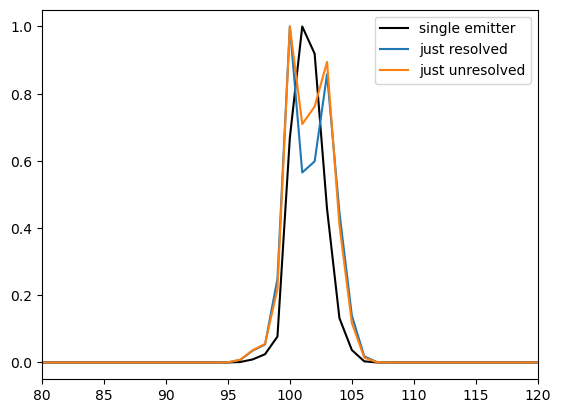

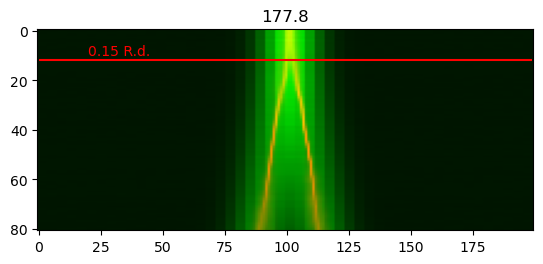

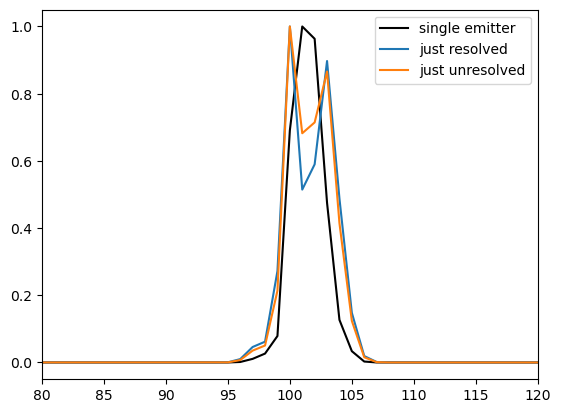

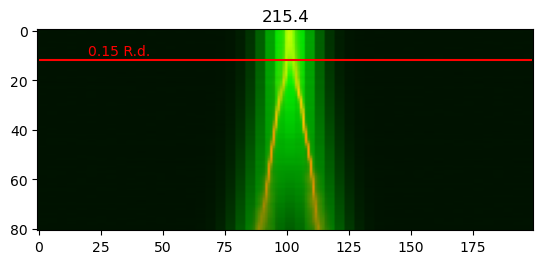

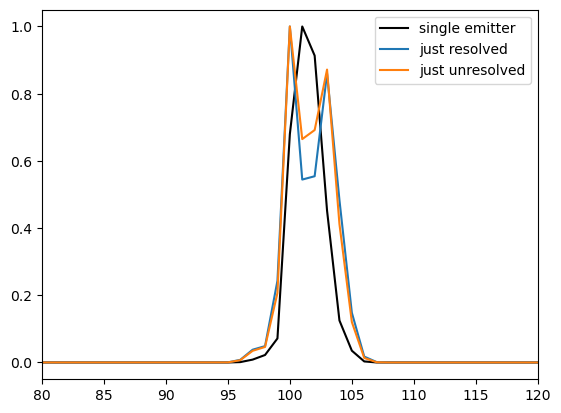

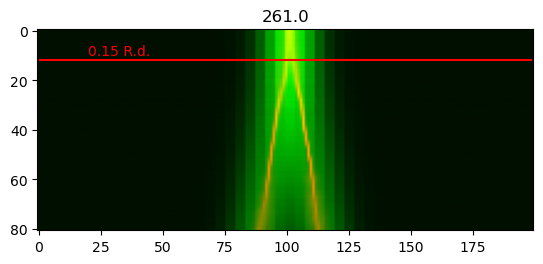

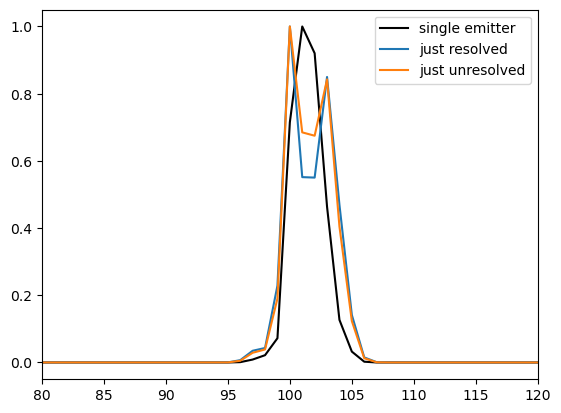

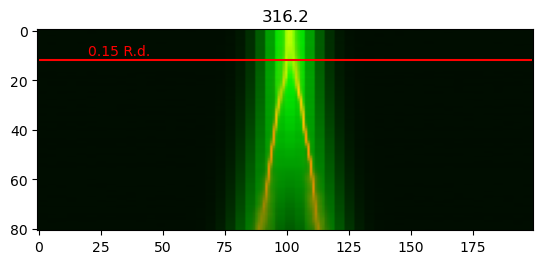

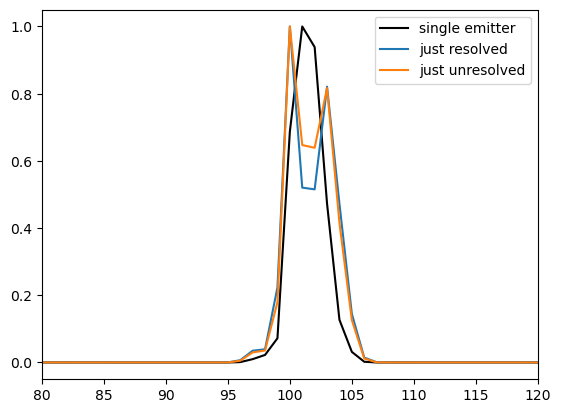

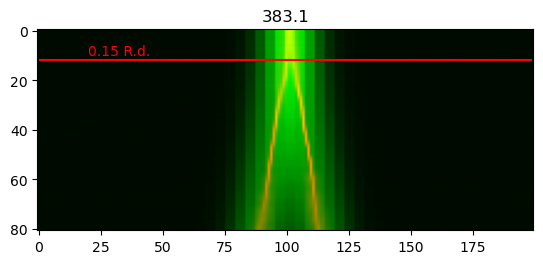

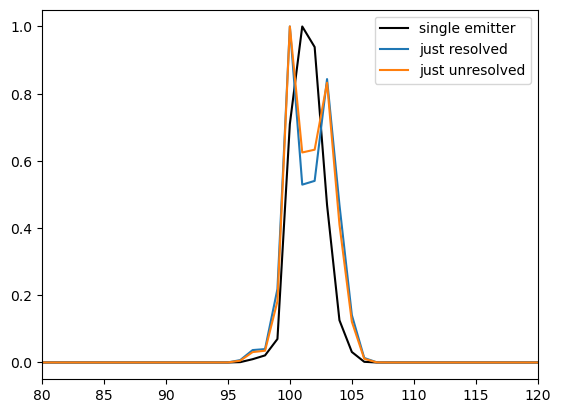

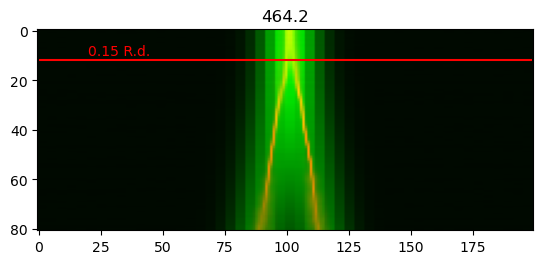

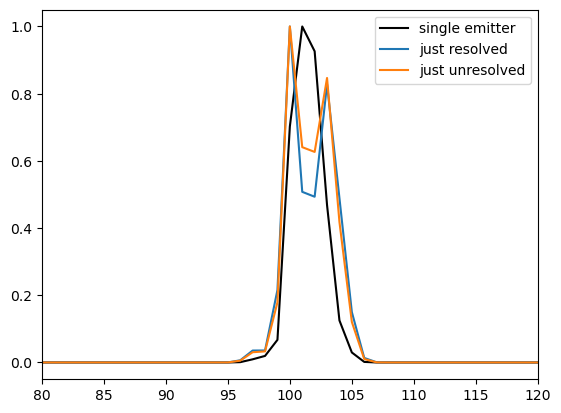

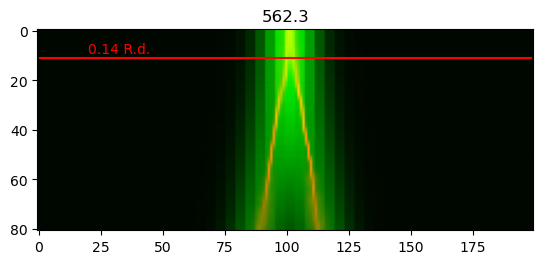

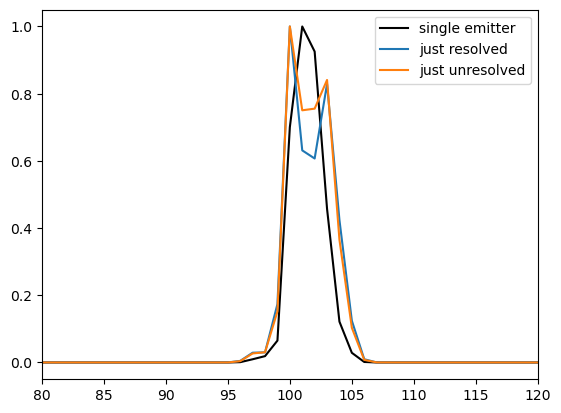

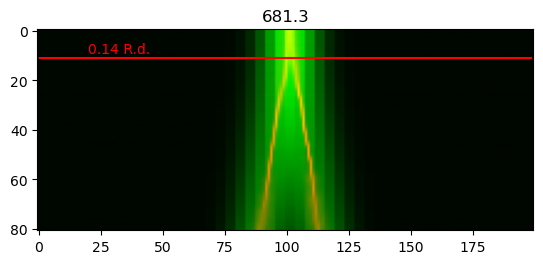

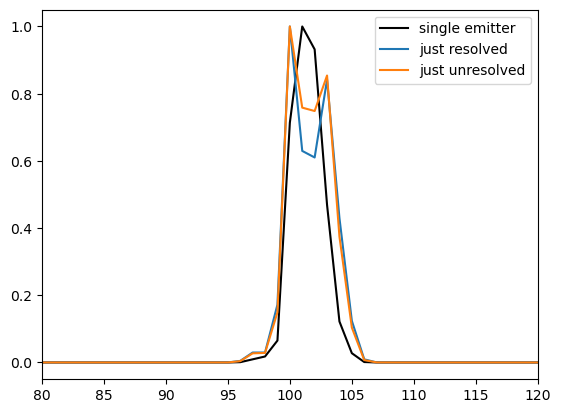

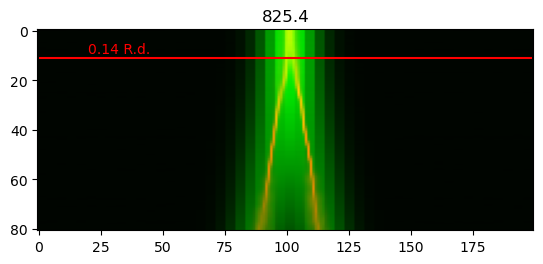

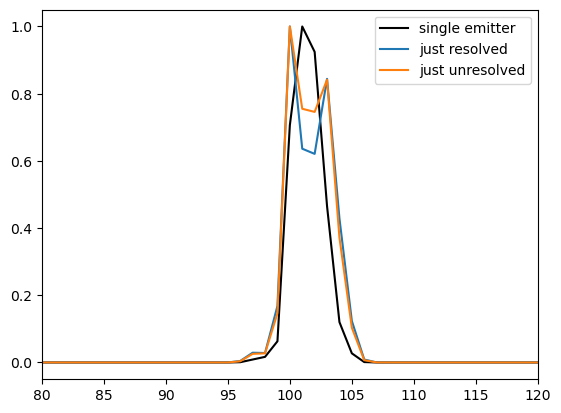

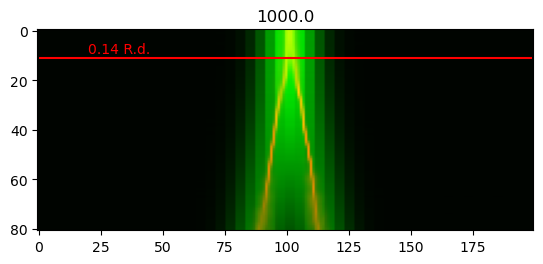

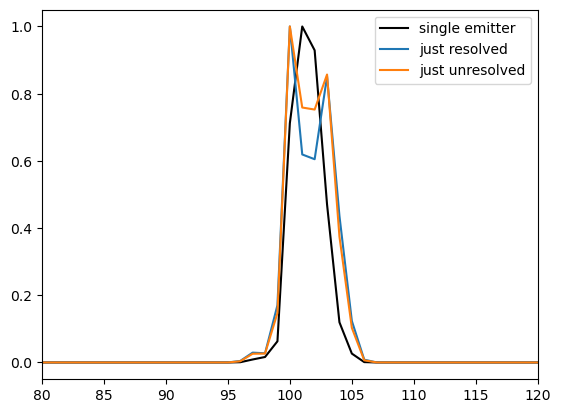

In [8]:
def plot_estimate_resolution(snrkey):
    keys = snr_groups.get(snrkey)
    if float(snrkey)<10:
        return None
    
    ones = np.ones(4)
    arr = []
    arr2 = []
    for key in keys:        
        arr.append(np.array([np.mean(im, axis=0) for im in cnndata[key]]))
        arr2.append(np.array([np.kron(np.mean(im, axis=0), ones) for im in inpdata[key]]))
    arr = np.mean(np.array(arr), axis=0) #XXX
    arr2 = np.mean(np.array(arr2), axis=0)
    arr /= np.max(arr)
    arr2 /= np.max(arr2)
    resolvable = np.array([is_resolvable(y) for y in arr])
    inconclusive = False
    if resolvable[0]:
        inconclusive = True
    win = 1
    cres = [np.all(resolvable[i:i+win]) for i in range(len(resolvable)-win)]
    thr = np.where(cres)[0]
    if len(thr) > 0:
        thr = thr[0]
    else:
        thr = 0
    
    composite = np.zeros((81,200,3))
    composite[:,:,0] = arr**0.5
    composite[:,:,1] = arr2
    plt.imshow(composite)
    plt.title(snrkey)
    if not inconclusive:
        plt.hlines(thr, 0, 199, colors='r')
        plt.annotate(f'{distances[thr]/RAYLEIGH:.2f} R.d.', (20, thr-2), c='r')
        plt.show()
        plt.plot(arr[0]/np.max(arr[0]), c='k', label='single emitter')
        plt.plot(arr[thr]/np.max(arr[thr]), label='just resolved')
        plt.xlim(80,120)
        if thr > 1:
            plt.plot(arr[thr-1]/np.max(arr[thr-1]), label='just unresolved')
        plt.legend()
        plt.show()
    else:
        plt.title(snrkey+'???!')
        plt.show()
        plt.plot(arr[0])
        plt.show()
    plt.show()

for skey in sorted_snr_keys[5:]:    
    plot_estimate_resolution(skey)

In [9]:
# Process noiseless dataset, as a limit of high SNR
arr = np.mean(cnndata['noiseless'], axis=1)
resolvable = np.array([is_resolvable(y) for y in arr])
index = np.where(resolvable)[0][0]
print(f"Last unresolvable distnace: {distances[index-1]/RAYLEIGH:.3f} of Rayleigh distances.")
print(f"First resolvable distnace: {distances[index]/RAYLEIGH:.3f} of Rayleigh distances.")


Last unresolvable distnace: 0.125 of Rayleigh distances.
First resolvable distnace: 0.138 of Rayleigh distances.
